In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns 
from nilearn import datasets, image, plotting
from nilearn.image import clean_img
from nilearn.image import resample_to_img
import nibabel as nib
import pandas as pd
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.input_data import NiftiMasker
import os

C:\Users\siyap\AppData\Local\Temp\ipykernel_15904\317244348.py:11: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiMasker


In [2]:
atlas = fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')
atlas_filename = atlas.filename
labels = atlas.labels

for i, lab in enumerate(labels):
    if "Amygdala" in lab:
        print(i, lab)

[fetch_atlas_harvard_oxford] Dataset found in C:\Users\siyap\nilearn_data\fsl

10 Left Amygdala
20 Right Amygdala


In [3]:
atlas_img = nib.load(atlas_filename)
atlas_data = atlas_img.get_fdata()

label_index = [10,20]
print(atlas_img.affine)

[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


In [4]:
left_amygdala_mask_data = (atlas_data == label_index[0]).astype(int)

left_mask_img = nib.Nifti1Image(left_amygdala_mask_data, affine=atlas_img.affine, dtype = 'float')
nib.save(left_mask_img, "left_amygdala_mask.nii.gz")

right_amygdala_mask_data = (atlas_data == label_index[1]).astype(int)

right_mask_img = nib.Nifti1Image(right_amygdala_mask_data, affine=atlas_img.affine, dtype = 'float')
nib.save(right_mask_img, "right_amygdala_mask.nii.gz")

In [5]:
Bold_BigBuckBunny_Folder = r"C:\Users\siyap\OneDrive\Documents\BigBuckBunnyBOLDdata"
output_folder = "Subject_Extracted_Amaygdala_Only_Timeseries"

left_masker = NiftiMasker(
    mask_img=left_mask_img,
    standardize=True,
    detrend=True,
)
left_masker.fit()

right_masker = NiftiMasker(
    mask_img=right_mask_img,
    standardize=True,
    detrend=True,
)

right_masker.fit()

for subject_BigBuckBunny in os.listdir(Bold_BigBuckBunny_Folder):
    if subject_BigBuckBunny.endswith(".nii.gz"):
        subject_file = os.path.join(Bold_BigBuckBunny_Folder, subject_BigBuckBunny)
        subject_id = subject_BigBuckBunny.replace("task-BigBuckBunny_space-MNI_desc-ppres_bold.nii.gz", "")
        print(f"Processing {subject_id}")
        output_csv = os.path.join(output_folder, f"{subject_id}_amygdala_timeseries.csv")
        
        if os.path.exists(output_csv):
            print(f"CSV for {subject_id} already exists. Skipping...")
            continue
            
        bold_img = nib.load(subject_file)

        
        left_ts = left_masker.transform(bold_img)

        right_ts = right_masker.transform(bold_img)
        
        n_timepoints = left_ts.shape[0]
        time_sec = np.arange(n_timepoints)

        df = pd.DataFrame({
            "time": time_sec,
            "left_amygdala": left_ts[:, 0],
            "right_amygdala": right_ts[:, 0]
        })
        
        df.to_csv(f"{output_folder}/{subject_id}_amygdala_timeseries.csv", index=False)
        print(f"Saved {subject_id}_amygdala_timeseries.csv")

C:\Users\siyap\AppData\Local\Temp\ipykernel_15904\890385359.py:9: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  left_masker.fit()
C:\Users\siyap\AppData\Local\Temp\ipykernel_15904\890385359.py:17: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  right_masker.fit()


Processing sub-S01_ses-1_
CSV for sub-S01_ses-1_ already exists. Skipping...
Processing sub-S02_ses-2_
CSV for sub-S02_ses-2_ already exists. Skipping...
Processing sub-S03_ses-4_
CSV for sub-S03_ses-4_ already exists. Skipping...
Processing sub-S04_ses-3_
CSV for sub-S04_ses-3_ already exists. Skipping...
Processing sub-S05_ses-1_
CSV for sub-S05_ses-1_ already exists. Skipping...
Processing sub-S06_ses-3_
CSV for sub-S06_ses-3_ already exists. Skipping...
Processing sub-S07_ses-3_
CSV for sub-S07_ses-3_ already exists. Skipping...
Processing sub-S08_ses-3_
CSV for sub-S08_ses-3_ already exists. Skipping...
Processing sub-S09_ses-1_
CSV for sub-S09_ses-1_ already exists. Skipping...
Processing sub-S10_ses-4_
CSV for sub-S10_ses-4_ already exists. Skipping...
Processing sub-S11_ses-1_
CSV for sub-S11_ses-1_ already exists. Skipping...
Processing sub-S13_ses-2_
CSV for sub-S13_ses-2_ already exists. Skipping...
Processing sub-S14_ses-4_
CSV for sub-S14_ses-4_ already exists. Skipping...

The minimum length is: 528
Number of Subjects: 30


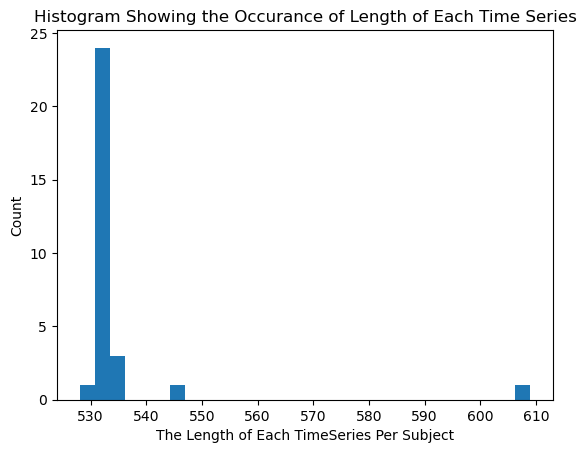

In [18]:
Subject_Extracted_Amaygdala_Only_Timeseries = "Subject_Extracted_Amaygdala_Only_Timeseries"

len_dfs_vals = []
dfs_raw = []

for subject_amygdala in os.listdir(Subject_Extracted_Amaygdala_Only_Timeseries):
    if subject_amygdala.endswith(".csv"):
        file_path = os.path.join(Subject_Extracted_Amaygdala_Only_Timeseries, subject_amygdala)
        subject_df = pd.read_csv(file_path)
        #print(f"The length of the time series for {subject_amygdala}: {len(subject_df)}")
        len_dfs_vals.append(len(subject_df))
        dfs_raw.append(subject_df)

len_dfs_vals = np.array(len_dfs_vals)
print(f"The minimum length is: {np.min(len_dfs_vals)}")
print(f"Number of Subjects: {len(len_dfs_vals)}")

plt.hist(len_dfs_vals, bins = 30)
plt.xlabel("The Length of Each TimeSeries Per Subject")
plt.ylabel("Count")
plt.title("Histogram Showing the Occurance of Length of Each Time Series")
plt.show()

In [19]:
dfs_impute = []
for df in dfs_raw:
    dfs_impute.append(df.iloc[:528].reset_index(drop=True))
print(len(dfs_impute))

30


In [14]:
column_tuples = []

for i in range(len(dfs_impute)):
    for hemi in ['left', 'right']:
        column_tuples.append((f"subject_{i}", hemi))

columns = pd.MultiIndex.from_tuples(column_tuples)

data_list = []

for df in dfs_impute:
    data_list.append(df.iloc[:, 1:3].values)

data = np.column_stack(data_list)

master_df_init = pd.DataFrame(data, columns=columns)

In [26]:
master_df_init

subject_0           subject_1           subject_2           subject_3  \
         left     right      left     right      left     right      left   
0   -0.724043 -0.474626 -0.654173 -0.036526 -1.101399  0.255650 -0.665875   
1   -1.241806  0.249143  0.289145 -0.057251 -1.391204  0.726389 -1.046834   
2   -0.586585 -0.587162 -0.721658 -0.894314 -0.440272  1.443644 -1.893001   
3    0.683273  0.236537  0.304811  0.411332  0.772975 -0.096510 -1.336801   
4    0.310507  0.203368  0.230357 -1.433806 -0.026342  0.949549 -1.258972   
..        ...       ...       ...       ...       ...       ...       ...   
523 -0.295987  0.470428  0.838334 -1.121125  1.204350  0.581191 -0.083998   
524 -0.300261  0.827351  0.010546 -1.276964 -0.128276  0.302280  1.221551   
525  1.454496 -0.778130  3.273488 -1.961161 -0.111441 -0.536488 -0.234925   
526  0.341309  0.105951  0.060856 -1.645570 -0.429789  0.074448  0.201250   
527  0.559487  1.058889  0.206309 -1.274101 -0.213287  0.293921  0.850616   

              subject_4            ... subject_25           subject_26  \
        right      left     right  ...       left     right       left   
0    1.384612  0.250878  0.071375  ...  -0.476291 -1.321534  -1.092369   
1    0.760846  1.997693  0.106080  ...  -2.301065  0.889285   0.059911   
2   -1.482707  1.345969  0.196930  ...  -1.896694  0.312375   1.971721   
3   -0.195149  1.341584  0.240217  ...  -0.579941  0.130311   0.336900   
4   -0.671908  0.327529  0.002614  ...   0.196563  0.877104  -0.620652   
..        ...       ...       ...  ...        ...       ...        ...   
523  0.747159  0.786035 -1.200149  ...   1.359247 -0.390796  -0.057738   
524 -0.839555  1.540896  0.569430  ...   0.595575 -0.622517   0.311338   
525  2.725411  1.411557  1.826147  ...   0.224186 -1.128196  -0.049695   
526  0.043955  0.964449  1.067306  ...   1.318863 -2.344816   0.502575   
527 -0.976913  1.600854  0.460463  ...   1.312575 -1.367249   0.367078   

              subject_27           subject_28           subject_29            
        right       left     right       left     right       left     right  
0   -1.344269   1.011459  0.826288  -0.596787  1.481181   0.805425  3.017232  
1    1.328136   1.543867 -0.021904   0.863478  2.288082   1.703162  1.154805  
2   -0.486321  -1.212609  0.075578  -1.176731  1.650930  -0.730842  0.648854  
3   -0.256834   0.996174 -0.192856  -0.792236 -0.703110   1.976824  0.494694  
4   -0.998867  -0.776359  0.474093   0.868483  0.544639  -0.147729  1.464566  
..        ...        ...       ...        ...       ...        ...       ...  
523 -0.707169   0.331933  1.081779  -0.517540 -0.284255   1.321021  1.534357  
524 -0.345230   0.327413  0.884080   0.538849  1.302644  -0.148147 -0.473591  
525 -0.125431  -0.261789  1.448732   0.940224 -0.156144   1.858969  1.876575  
526  0.141820   0.802197  1.349251   0.315911 -0.187054  -0.181112 -0.501251  
527  1.249728   0.759292  0.664094  -0.199954 -0.596935   2.068090  0.721728  

[528 rows x 60 columns]

In [40]:
amyg_leftright_corr_values = {}
subjects = master_df_init.columns.get_level_values(0).unique()

for subject in subjects:
    left_series = master_df_init[(subject, 'left')]
    right_series = master_df_init[(subject, 'right')]

    corr_value = left_series.corr(right_series)

    amyg_leftright_corr_values[subject] = corr_value
corr_df = pd.DataFrame.from_dict(amyg_leftright_corr_values, orient='index', columns=['Hemisphere Amygdala Corr'])
print(corr_df)

            Hemisphere Amygdala Corr
subject_0                  -0.121042
subject_1                  -0.214678
subject_2                  -0.148826
subject_3                   0.064050
subject_4                   0.174260
subject_5                  -0.253387
subject_6                   0.224758
subject_7                   0.014175
subject_8                   0.043338
subject_9                   0.081396
subject_10                 -0.156435
subject_11                  0.094584
subject_12                  0.163320
subject_13                 -0.216541
subject_14                  0.288615
subject_15                  0.058579
subject_16                  0.096369
subject_17                  0.085473
subject_18                  0.313335
subject_19                  0.049892
subject_20                 -0.038885
subject_21                  0.195518
subject_22                  0.029552
subject_23                  0.038432
subject_24                 -0.117007
subject_25                  0.096483
s

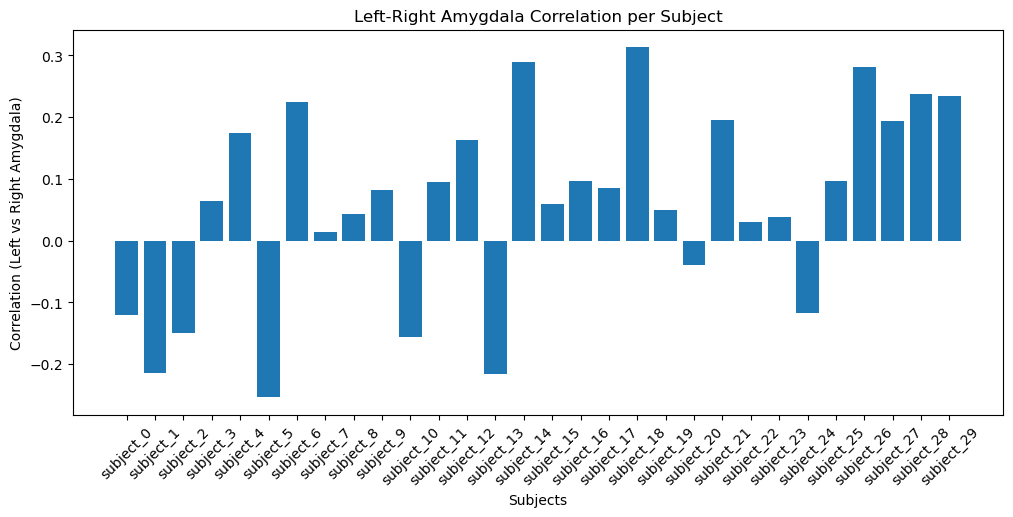

In [41]:
plt.figure(figsize=(12,5))
plt.bar(corr_df.index, corr_df['Hemisphere Amygdala Corr'])
plt.xticks(rotation=45)
plt.ylabel("Correlation (Left vs Right Amygdala)")
plt.xlabel("Subjects")
plt.title("Left-Right Amygdala Correlation per Subject")
plt.show()

In [49]:
left_amygdala_series_std = []
right_amygdala_series_std = []

for subject in subjects:
    left_series = master_df_init[(subject, "left")]
    right_series = master_df_init[(subject, "right")]
    
    left_amygdala_series_std.append(left_series.std())
    right_amygdala_series_std.append(right_series.std())

levene_stat, levene_p = sp.stats.levene(left_amygdala_series_std, right_amygdala_series_std)

shapiro_left_stat, shapiro_left_p = sp.stats.shapiro(left_amygdala_series_std)
shapiro_right_stat, shapiro_right_p = sp.stats.shapiro(right_amygdala_series_std)

mannwhitu_stat, mannwhitu_p = sp.stats.mannwhitneyu(left_amygdala_series_std, right_amygdala_series_std)  

print(f"Levene test statistic: {levene_stat}, p-value: {levene_p}")

print(f"Left Amygdala Shapiro:{shapiro_left_stat}, p = {shapiro_left_p}")
print(f"Right Aymgdala Shapiro:{shapiro_right_stat}, p = {shapiro_right_p}")
print(f"Mann Whitney U test statistic: {mannwhitu_stat}, p-value: {mannwhitu_p}")

Levene test statistic: 1.9474045868159249, p-value: 0.16818688894871228
Left Amygdala Shapiro:0.9259106662935878, p = 0.038279417462977
Right Aymgdala Shapiro:0.4822155963172401, p = 3.4934063440042073e-09
Mann Whitney U test statistic: 486.0, p-value: 0.5996894845123704


In [52]:
master_df_output_folder = "Master_Data_Files"
master_df_init.to_csv(f"{master_df_output_folder}/master_df.csv", index=False)